# Summary report on temperature datasets

In this notebook we inspect the temperature datasets
along with the station metadata.

At the end, a figure showing the locations of the sites on a map is generated.

In [1]:
# boilerplate includes
import sys
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
import matplotlib.patheffects as path_effects

import pandas as pd
import seaborn as sns

import datetime
# import scipy.interpolate
# import re

from IPython.display import display, HTML
%matplotlib notebook
plt.style.use('seaborn-notebook')

pd.set_option('display.max_columns', None)

## Constants / Parameters

In [2]:
STATIONS = [
            'KLAX',
            'KSFO',
            'KSAN',
            'KMIA',
            'KFAT',
            'KJAX',
            'KTPA',
            'KRIV',
            'KIAH',
            'KMCO',
            'KBUR',
#             'KSNA', # Not good
#             'KONT', # Not good, 1973+ might be usable but 2001 has an 86 day and 41 day gap.
#             'KHST', # Not good
#             'KFUL', # Bad
            ]

TEMPERATURE_DATADIR = '../data/temperatures'

# The label of the hourly temperature column
TEMP_COL = 'AT'

# Gaps in the data this big or longer will be considerd 'breaks'... 
# so the 'good' continuous timeseries will start at the end of the last big gap
BIG_GAP_LENGTH = pd.Timedelta('14 days')

# # Time range to use for computing normals (30 year, just like NOAA uses)
# NORM_IN_START_DATE = '1986-07-01'
# NORM_IN_END_DATE = '2016-07-01'
# # Time range or normals to output to use when running 'medfoes on normal temperature' (2 years, avoiding leapyears)
# NORM_OUT_START_DATE = '2014-01-01'
# NORM_OUT_END_DATE = '2015-12-31 23:59:59'

In [3]:
def read_isd_history_stations_list(filename, skiprows=22):
    """Read and parse stations information from isd_history.txt file"""
    fwfdef = (( ('USAF', (6, str)),
                ('WBAN', (5, str)),
                ('STATION NAME', (28, str)),
                ('CTRY', (4, str)),
                ('ST', (2, str)),
                ('CALL', (5, str)),
                ('LAT', (7, str)),
                ('LON', (8, str)),
                ('EVEV', (7, str)),
                ('BEGIN', (8, str)),
                ('END', (8, str)),
                ))
    names = []
    colspecs = []
    converters = {}
    i = 0
    for k,v in fwfdef:
        names.append(k)
        colspecs.append((i, i+v[0]+1))
        i += v[0]+1
        converters[k] = v[1]
    stdf = pd.read_fwf(filename, skiprows=skiprows,
                       names=names,
                       colspecs=colspecs,
                       converters=converters)
    return stdf

## Read the cleaned temperature data for each site
Also load the "gaps" file which was generated for each site by the cleaning temperatures script.

We will use this information to identify at what point the data no longer contains 
any gaps bigger than `BIG_GAP_LENGTH`

In [4]:
#df = pd.DataFrame(columns=['callsign', 'data start', 'data end', 'good start', 'gaps after good start'],

tmp = []

for callsign in STATIONS:

    # load the temperature dataset
    fn = "{}_AT_cleaned.h5".format(callsign)
    ot = pd.read_hdf(os.path.join(TEMPERATURE_DATADIR,fn), 'table')

    # load the gaps information
    gaps = pd.read_csv(os.path.join(TEMPERATURE_DATADIR,"{}_AT_gaps.tsv".format(callsign)),
                       sep='\t', comment='#',
                       names=['begin','end','length'],
                      parse_dates=[0,1])
    # convert length to an actual timedelta
    gaps['length'] = pd.to_timedelta(gaps['length'])
    # make sure begin and end have the right timezone association (UTC)
    gaps['begin'] = gaps['begin'].apply(lambda x: x.tz_localize('UTC'))
    gaps['end'] = gaps['end'].apply(lambda x: x.tz_localize('UTC'))
    
    big_gaps = gaps[gaps['length'] >= BIG_GAP_LENGTH]
    end_of_last_big_gap = big_gaps['end'].max()
    if pd.isnull(end_of_last_big_gap): # No big gaps... so use start of data
        end_of_last_big_gap = ot.index[0]
    num_gaps_after_last_big_gap = gaps[gaps['end'] > end_of_last_big_gap].shape[0]
    
    print(callsign,
          ot.index[0],
          ot.index[-1],
          end_of_last_big_gap,
          num_gaps_after_last_big_gap,
          sep='\t')

    tmp.append([
        callsign,
        ot.index[0],
        ot.index[-1],
        end_of_last_big_gap,
        num_gaps_after_last_big_gap,
        ])

    #display(big_gaps)

df = pd.DataFrame(tmp, columns=['callsign', 'data start', 'data end', 'good start', 'gaps after good start']).set_index('callsign')

KLAX	1944-01-02 00:00:00+00:00	2017-05-15 23:00:00+00:00	1947-01-01 14:00:00+00:00	6
KSFO	1948-01-02 00:00:00+00:00	2017-05-16 23:00:00+00:00	1948-01-02 00:00:00+00:00	164
KSAN	1942-01-01 00:00:00+00:00	2017-05-16 23:00:00+00:00	1948-01-01 14:00:00+00:00	166
KMIA	1948-01-01 00:00:00+00:00	2017-05-16 23:00:00+00:00	1948-01-01 00:00:00+00:00	157
KFAT	1941-12-04 00:00:00+00:00	2017-05-17 23:00:00+00:00	1949-08-21 14:00:00+00:00	75
KJAX	1948-01-01 00:00:00+00:00	2017-05-17 23:00:00+00:00	1948-01-01 00:00:00+00:00	68
KTPA	1940-08-01 00:00:00+00:00	2017-05-17 23:00:00+00:00	1948-01-01 11:00:00+00:00	67
KRIV	1933-01-02 00:00:00+00:00	2017-05-17 23:00:00+00:00	1941-09-01 08:00:00+00:00	160
KIAH	1969-06-01 00:00:00+00:00	2017-05-16 23:00:00+00:00	1969-06-01 00:00:00+00:00	32
KMCO	1952-05-08 00:00:00+00:00	2017-05-17 23:00:00+00:00	1973-01-01 00:00:00+00:00	5
KBUR	1943-06-01 00:00:00+00:00	2017-05-17 23:00:00+00:00	1973-01-01 00:00:00+00:00	375


#### The `'good start'` column contains the date after which there are no longer any gaps bigger than `BIG_GAP_LENGTH`

In [5]:
df['good start']

callsign
KLAX   1947-01-01 14:00:00+00:00
KSFO   1948-01-02 00:00:00+00:00
KSAN   1948-01-01 14:00:00+00:00
KMIA   1948-01-01 00:00:00+00:00
KFAT   1949-08-21 14:00:00+00:00
KJAX   1948-01-01 00:00:00+00:00
KTPA   1948-01-01 11:00:00+00:00
KRIV   1941-09-01 08:00:00+00:00
KIAH   1969-06-01 00:00:00+00:00
KMCO   1973-01-01 00:00:00+00:00
KBUR   1973-01-01 00:00:00+00:00
Name: good start, dtype: datetime64[ns, UTC]

### Read the `isd-history.txt` metadata file
Only take rows where the callsign matches one we are interested in.  
There will be multiple entries for each callsign.
Station data formats and id numbers changed over the years.
Also, sometimes stations were moved (small distances).
These changes resulted in separate entries with the same callsign.


In [6]:
historydf = read_isd_history_stations_list(
    os.path.join(TEMPERATURE_DATADIR,'ISD/isd-history.txt'))
df.join(historydf.set_index('CALL'))

,data start,data end,good start,gaps after good start,USAF,WBAN,STATION NAME,CTRY,ST,LAT,LON,EVEV,BEGIN,END
KBUR,1943-06-01 00:00:00+00:00,2017-05-17 23:00:00+00:00,1973-01-01 00:00:00+00:00,375,722880,23152,BURBANK-GLENDALE-PASA ARPT,US,CA,+34.201,-118.358,+0236.2,19430601,20170720
KBUR,1943-06-01 00:00:00+00:00,2017-05-17 23:00:00+00:00,1973-01-01 00:00:00+00:00,375,722880,99999,BURBANK/GLENDALE,US,CA,+34.200,-118.350,+0236.0,20000101,20031231
KBUR,1943-06-01 00:00:00+00:00,2017-05-17 23:00:00+00:00,1973-01-01 00:00:00+00:00,375,999999,23152,HOLLYWOOD BURBANK ARPT,US,CA,+34.201,-118.358,+0223.1,19480101,19690101
KFAT,1941-12-04 00:00:00+00:00,2017-05-17 23:00:00+00:00,1949-08-21 14:00:00+00:00,75,723890,93193,FRESNO YOSEMITE INTERNATIONAL,US,CA,+36.780,-119.719,+0101.5,19411204,20170720
KFAT,1941-12-04 00:00:00+00:00,2017-05-17 23:00:00+00:00,1949-08-21 14:00:00+00:00,75,999999,93193,FRESNO YOSEMITE INTL AP,US,CA,+36.780,-119.719,+0099.7,19650101,19711231
KIAH,1969-06-01 00:00:00+00:00,2017-05-16 23:00:00+00:00,1969-06-01 00:00:00+00:00,32,722430,12960,G BUSH INTERCONTINENTAL AP/HO,US,TX,+29.980,-095.360,+0029.0,19730101,20170720
KIAH,1969-06-01 00:00:00+00:00,2017-05-16 23:00:00+00:00,1969-06-01 00:00:00+00:00,32,999999,12960,HOUSTON INTERCONTINENTAL AP,US,TX,+29.980,-095.360,+0032.0,19690601,19721231
KJAX,1948-01-01 00:00:00+00:00,2017-05-17 23:00:00+00:00,1948-01-01 00:00:00+00:00,68,722060,13889,JACKSONVILLE INTERNATIONAL A,US,FL,+30.495,-081.694,+0007.9,19480101,20170720
KJAX,1948-01-01 00:00:00+00:00,2017-05-17 23:00:00+00:00,1948-01-01 00:00:00+00:00,68,999999,13889,JACKSONVILLE IMESON,US,FL,+30.495,-081.694,+0009.8,19660101,19721231
KLAX,1944-01-02 00:00:00+00:00,2017-05-15 23:00:00+00:00,1947-01-01 14:00:00+00:00,6,722950,23174,LOS ANGELES INTERNATIONAL AIR,US,CA,+33.938,-118.389,+0029.6,19440101,20170720


### Take just the entry with the most recent data for each station callsign
We will use this most recent entry for the site location.  
If the station was moved, this is location won't be precisely correct for older data, 
but is should be quite close and good enough for our purporses.

In [7]:
sthistdf = historydf.set_index('CALL').loc[df.index]
sthistdf = sthistdf.reset_index().sort_values(['CALL','END'], ascending=[True,False]).set_index('CALL')

foo = sthistdf[~sthistdf.index.duplicated('first')]
foo = foo.join(df)
foo.drop('END',1, inplace=True)
foo.drop('BEGIN',1, inplace=True)

foo = foo.reindex(STATIONS)
foo

,USAF,WBAN,STATION NAME,CTRY,ST,LAT,LON,EVEV,data start,data end,good start,gaps after good start
CALL,,,,,,,,,,,,
KLAX,722950,23174,LOS ANGELES INTERNATIONAL AIR,US,CA,+33.938,-118.389,+0029.6,1944-01-02 00:00:00+00:00,2017-05-15 23:00:00+00:00,1947-01-01 14:00:00+00:00,6
KSFO,724940,23234,SAN FRANCISCO INTERNATIONAL A,US,CA,+37.620,-122.365,+0002.4,1948-01-02 00:00:00+00:00,2017-05-16 23:00:00+00:00,1948-01-02 00:00:00+00:00,164
KSAN,722900,23188,SAN DIEGO INTERNATIONAL AIRPO,US,CA,+32.734,-117.183,+0004.6,1942-01-01 00:00:00+00:00,2017-05-16 23:00:00+00:00,1948-01-01 14:00:00+00:00,166
KMIA,722020,12839,MIAMI INTERNATIONAL AIRPORT,US,FL,+25.791,-080.316,+0008.8,1948-01-01 00:00:00+00:00,2017-05-16 23:00:00+00:00,1948-01-01 00:00:00+00:00,157
KFAT,723890,93193,FRESNO YOSEMITE INTERNATIONAL,US,CA,+36.780,-119.719,+0101.5,1941-12-04 00:00:00+00:00,2017-05-17 23:00:00+00:00,1949-08-21 14:00:00+00:00,75
KJAX,722060,13889,JACKSONVILLE INTERNATIONAL A,US,FL,+30.495,-081.694,+0007.9,1948-01-01 00:00:00+00:00,2017-05-17 23:00:00+00:00,1948-01-01 00:00:00+00:00,68
KTPA,722110,12842,TAMPA INTERNATIONAL AIRPORT,US,FL,+27.962,-082.540,+0005.8,1940-08-01 00:00:00+00:00,2017-05-17 23:00:00+00:00,1948-01-01 11:00:00+00:00,67
KRIV,722860,23119,MARCH AIR RESERVE BASE,US,CA,+33.900,-117.250,+0468.2,1933-01-02 00:00:00+00:00,2017-05-17 23:00:00+00:00,1941-09-01 08:00:00+00:00,160
KIAH,722430,12960,G BUSH INTERCONTINENTAL AP/HO,US,TX,+29.980,-095.360,+0029.0,1969-06-01 00:00:00+00:00,2017-05-16 23:00:00+00:00,1969-06-01 00:00:00+00:00,32


In [9]:
# Save the summary table
foo.to_csv('stations_summary.csv')

In [11]:
tmp = foo[['STATION NAME','ST','LAT','LON',
           'EVEV','good start','data end']].sort_values(['ST','LAT'], ascending=[True,False])
display(tmp)

,STATION NAME,ST,LAT,LON,EVEV,good start,data end
CALL,,,,,,,
KSFO,SAN FRANCISCO INTERNATIONAL A,CA,+37.620,-122.365,+0002.4,1948-01-02 00:00:00+00:00,2017-05-16 23:00:00+00:00
KFAT,FRESNO YOSEMITE INTERNATIONAL,CA,+36.780,-119.719,+0101.5,1949-08-21 14:00:00+00:00,2017-05-17 23:00:00+00:00
KBUR,BURBANK-GLENDALE-PASA ARPT,CA,+34.201,-118.358,+0236.2,1973-01-01 00:00:00+00:00,2017-05-17 23:00:00+00:00
KLAX,LOS ANGELES INTERNATIONAL AIR,CA,+33.938,-118.389,+0029.6,1947-01-01 14:00:00+00:00,2017-05-15 23:00:00+00:00
KRIV,MARCH AIR RESERVE BASE,CA,+33.900,-117.250,+0468.2,1941-09-01 08:00:00+00:00,2017-05-17 23:00:00+00:00
KSAN,SAN DIEGO INTERNATIONAL AIRPO,CA,+32.734,-117.183,+0004.6,1948-01-01 14:00:00+00:00,2017-05-16 23:00:00+00:00
KJAX,JACKSONVILLE INTERNATIONAL A,FL,+30.495,-081.694,+0007.9,1948-01-01 00:00:00+00:00,2017-05-17 23:00:00+00:00
KMCO,ORLANDO INTERNATIONAL AIRPORT,FL,+28.434,-081.325,+0027.4,1973-01-01 00:00:00+00:00,2017-05-17 23:00:00+00:00
KTPA,TAMPA INTERNATIONAL AIRPORT,FL,+27.962,-082.540,+0005.8,1948-01-01 11:00:00+00:00,2017-05-17 23:00:00+00:00


# Sites Map figure

<IPython.core.display.Javascript object>


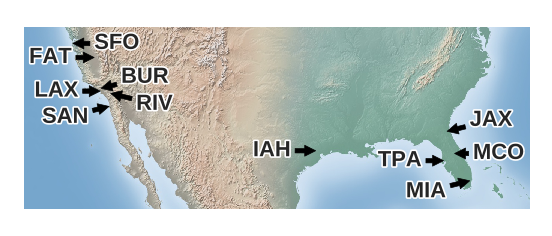

/home/travc/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/travc/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [12]:
fig = plt.figure(figsize=[3.5,1.5])
ax = fig.add_subplot(1,1,1)

# make the Basemap object which handles all the projection stuff for us
m = Basemap(width=5000000,height=1800000,
            resolution='c',projection='aea',
            lon_0=-99.4,lat_0=33)

# m.drawcoastlines(zorder=3)
m.shadedrelief()

# x,y = m(foo['LON'].values.astype(float), foo['LAT'].values.astype(float))
# m.scatter(x,y, marker='o', color='w', edgecolor='k', zorder=4)

for k,v in foo.iterrows():
    x,y = m(float(v['LON']), float(v['LAT']))
    if k in ['KSFO','KMCO']:
        txy = (20,0)
    elif k in ['KBUR','KJAX']:
        txy = (20,5)
    elif k in ['KRIV']:
        txy = (20,-5)
    elif k in ['KSAN','KMIA']:
        txy = (-20,-5)
    else:
        txy = (-20,0)
    a = ax.annotate(k[1:], xy=(x,y), xycoords='data',
                xytext=txy, textcoords='offset points',
                arrowprops=dict(color='k', arrowstyle='simple', shrinkA=0, shrinkB=0),
                ha='center', va='center',
                fontweight='bold',
                fontsize=10,
               )
    a.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white'),
                        path_effects.Normal()])

        
fig.patch.set_alpha(0)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')
fig.tight_layout()
fig.savefig('../figs/sitemap.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

# fig.savefig('sitemap.pdf')